<a href="https://colab.research.google.com/github/sanazy/Persian-Car-Licence-Plate-Detection-and-Recognition/blob/main/OCR_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
PATH = '/content/gdrive/MyDrive/DPA/'

images_path = PATH + "my_images/"
save_path = PATH + "my_output/"
weights_path = PATH + "my_weights/best.pt"
ocr_model_path = PATH + "ocr_model"

In [3]:
%cd {PATH}/yolov7

/content/gdrive/MyDrive/DPA/yolov7


## Import Packages

In [4]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sn
import cv2 as cv
from math import sqrt, atan, degrees

import tensorflow as tf
import keras
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import SGD

import argparse
import functools
from pathlib import Path
from typing import Union

import torch
from models.experimental import attempt_load
from utils.general import check_img_size
from utils.torch_utils import select_device, TracedModel
from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords
from utils.plots import plot_one_box, plot_one_box_PIL
from copy import deepcopy

from google.colab.patches import cv2_imshow

## Load Trained Plate Detection Model

In [5]:
device_id = 'cpu'
image_size = 640
trace = True

# Initialize
device = select_device(device_id)
half = device.type != 'cpu'  # half precision only supported on CUDA

In [6]:
# Load model
model = attempt_load(weights_path, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(image_size, s=stride)  # check img_size

if trace:
  model = TracedModel(model, device, image_size)

if half:
  model.half()  # to FP16
    
if device.type != 'cpu':
  model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



In [7]:
def detect_plate(source_image):
  # Padded resize
  img_size = 640
  stride = 32
  img = letterbox(source_image, img_size, stride=stride)[0]

  # Convert
  img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
  img = np.ascontiguousarray(img)
  img = torch.from_numpy(img).to(device)
  img = img.half() if half else img.float()  # uint8 to fp16/32
  img /= 255.0  # 0 - 255 to 0.0 - 1.0
  if img.ndimension() == 3:
    img = img.unsqueeze(0)
      
  with torch.no_grad():
    # Inference
    pred = model(img, augment=True)[0]

  # Apply NMS
  pred = non_max_suppression(pred, 0.25, 0.45, classes=0, agnostic=True)

  plate_detections = []
  det_confidences = []
  
  # Process detections
  for i, det in enumerate(pred):  # detections per image
    if len(det):
      # Rescale boxes from img_size to im0 size
      det[:, :4] = scale_coords(img.shape[2:], det[:, :4], source_image.shape).round()

      # Return results
      for *xyxy, conf, cls in reversed(det):
        coords = [int(position) for position in (torch.tensor(xyxy).view(1, 4)).tolist()[0]]
        plate_detections.append(coords)
        det_confidences.append(conf.item())

  return plate_detections, det_confidences

## Define Image Processing Functions

In [8]:
def crop(image, coord):
  cropped_image = image[int(coord[1]):int(coord[3]), int(coord[0]):int(coord[2])]
  return cropped_image

In [9]:
def find_longest_line(plate_img):
  kernel_size = 3
  blur_gray = cv.GaussianBlur(plate_img, (kernel_size, kernel_size), 0)

  low_threshold = 150
  high_threshold = 200

  edges = cv.Canny(blur_gray, low_threshold, high_threshold)

  rho = 1  # distance resolution in pixels of the Hough grid
  theta = np.pi / 180  # angular resolution in radians of the Hough grid
  threshold = 15  # minimum number of votes (intersections in Hough grid cell)
  min_line_length = 50  # minimum number of pixels making up a line
  max_line_gap = 5  # maximum gap in pixels between connectable line segments
  line_image = np.copy(plate_img) * 0  # creating a blank to draw lines on

  # Run Hough on edge detected image
  # Output "lines" is an array containing endpoints of detected line segments
  lines = cv.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                      min_line_length, max_line_gap)

  lls = []
  for indx, line in enumerate(lines):
    for x1,y1,x2,y2 in line:
      cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
      line_length = sqrt((x2-x1)**2 + (y2-y1)**2)
      lls.append((indx,line_length))
  lls.sort(key = lambda x: x[1])
  linessorted = []
  for (indx,ll) in lls:
    linessorted.append(lines[indx])
  return linessorted

def find_line_angle(line):
  x1,y1,x2,y2 = line[0]
  angle = degrees(atan(((y2-y1)/(x2-x1))))
  return angle

def rotate_image(plate_img_gr, angle):
  (h, w) = plate_img_gr.shape
  (cX, cY) = (w // 2, h // 2)
  M = cv.getRotationMatrix2D((cX, cY), angle, 1.0)
  rotated = cv.warpAffine(plate_img_gr, M, (w, h))
  return rotated

def adjust_cropping(rotated_img):
  h,w = rotated_img.shape
  targ_h = int(w/4)
  crop_h = int((h - targ_h)/2)
  cropped_rotated_img = rotated_img[crop_h:h-crop_h,:]
  return cropped_rotated_img

In [10]:
def preprocess_plate(image):
  
  resized_img = cv2.resize(image, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
  blur_img = cv2.GaussianBlur(resized_img, (5,5), 0)
  #print('Apply gaussian blur:')
  #cv2_imshow(blur_img)

  # perform otsu thresh (using binary inverse since opencv contours work better with white text)
  ret, thresh = cv2.threshold(blur_img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
  #print('Apply OTSU thereshold:')
  #cv2_imshow(thresh)
  rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  
  # apply dilation 
  dilated_img = cv2.dilate(thresh, rect_kern, iterations = 1)
  #print('Apply dilation:')
  #cv2_imshow(dilated_img)
  
  # find contours
  try:
    contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  except:
    ret_img, contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
  
  return resized_img, sorted_contours, thresh

In [11]:
def ocr_plate(image, sorted_contours, thresh):

  # create copy of image
  copy_img = image.copy()
  rois, Xs, Ys, Ws, Hs = [], [], [], [], []
  vehicle_plate = ""
  chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
           'A', 'B', 'D', 'Gh', 'H', 'J', 'L', 'M', 'N', 'P', 
           'PuV', 'PwD', 'Sad', 'Sin', 'T', 'Taxi', 'V', 'Y']

  # loop through contours and find letters in license plate
  for cnt in sorted_contours:
    # extract info of detected rectangle
    x,y,w,h = cv2.boundingRect(cnt)
    height, width = copy_img.shape
    
    # if height of box is not a quarter of total height then skip
    #if height / float(h) > 6: 
    #  continue
    ratio = h / float(w)
    # if height to width ratio is less than 1.5 skip
    if ratio < 0.8: 
      continue
    area = h * w
    # if width is not more than 25 pixels skip
    if width / float(w) > 25: 
      continue
    # if area is less than 100 pixels skip
    if area < 100: 
      continue
    # define roi
    roi = thresh[y-5:y+h+5, x-5:x+w+5]
    roi = cv2.bitwise_not(roi)
    roi = cv2.medianBlur(roi, 5)
    roi = cv2.resize(roi, (32, 32))
    rois.append(roi)
    Xs.append(x); Ys.append(y); Ws.append(w); Hs.append(h)

  # convert gray image to rgb to add colorful bounding box 
  copy_img = cv2.cvtColor(copy_img,cv2.COLOR_GRAY2RGB)

  # load the trained model for ocr
  ocr_model = tf.keras.models.load_model(ocr_model_path)
  # make prediction
  rois = np.array(rois) / 255.0
  pred = ocr_model.predict(rois)
  pred_labels = [np.argmax(i) for i in pred]
  
  for i, label in enumerate(pred_labels):
    # add each character to vehicle plate
    vehicle_plate += chars[label]
    # draw the rectangle on image
    cv2.rectangle(copy_img, (Xs[i], Ys[i]), (Xs[i]+Ws[i], Ys[i]+Hs[i]), (0,255,0),2)
    # write the character on image
    cv2.putText(copy_img, chars[label], (Xs[i], Ys[i]+10), 0, 0.7, (0, 0, 255), 2)

  return copy_img, vehicle_plate

In [12]:
def get_plates_from_image(image_name):
  
  # read the image
  image_path = os.path.join(images_path, image_name)
  image = cv.imread(image_path)
  
  if image is None:
    return None
  
  # detect the location and confidence level of plates in image
  plate_detections, det_confidences = detect_plate(image)
  copy_input = deepcopy(image)
  print("Orignial image:")
  cv2_imshow(copy_input)

  # for each detected plate
  for i, coords in enumerate(plate_detections):
    
    # crop the plate from original image
    plate_region = crop(copy_input, coords)

    # write the cropped plate 
    cv.imwrite(os.path.join(save_path, "plate_" + image_name), plate_region)
    # read the cropped plate as gray image
    gray_plate = cv2.imread(os.path.join(save_path, "plate_" + image_name), 0)

    try: 
      # find the longest line in the image
      linessorted = find_longest_line(gray_plate)
      # find the angle of longest line
      rot_angle = find_line_angle(linessorted[-1])

      # rotate and crop the image if rotation angle is greater than 10
      if (rot_angle > 10) or (rot_angle < -10):
        rotated_img = rotate_image(gray_plate, rot_angle)
        gray_plate = adjust_cropping(rotated_img)
    
    except:
      continue

    print("Plate region:")
    cv2_imshow(gray_plate)

    # preprocess the plate
    resized_image, contours, thresh = preprocess_plate(gray_plate)
    # character recognition of plate
    result_image, plate_text = ocr_plate(resized_image, contours, thresh)

    cv2_imshow(result_image)
    print("Plate number is: ", plate_text)

    # write the result image into drive
    cv.imwrite(os.path.join(save_path, "ocr_" + image_name), result_image)

  return plate_text, result_image

## Apply OCR on Detected Plates

Orignial image:


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


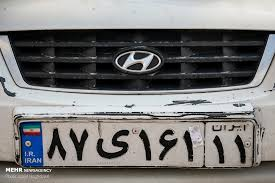

Plate region:


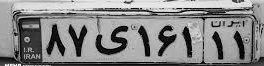

1/1 [==============================] - 0s 151ms/step


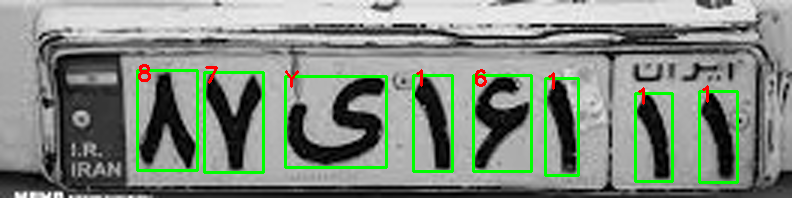

Plate number is:  87Y16111


In [13]:
image_name = 'image_8.jpeg'
plate_text, detected_plate = get_plates_from_image(image_name)